In [1]:
# Initial setup

try:
    plt_inline
except NameError:
    # Avoid small fonts when inlining again
    %matplotlib inline
    plt_inline = True
    
from inc.notebook001 import *

In [2]:
# Show when it happens in profiling and "full" execution.

In [3]:
def is_target(app):
    return app.stages[0].bytes_read > 8 * 10**6

def get_df_records(apps):
    ns_stages = set(len(app.stages) for app in apps)
    assert len(ns_stages) == 1, "{} stages found".format(len(ns_stages))
    n_stages = ns_stages.pop()
    # ['workers', 'samples', 'stage0read', 'stage0written', 'stage1read', ...]
    cols = ['workers', 'samples'] + ['stage{:d}{}'.format(stage, typ)
                                     for stage in range(n_stages)
                                     for typ in ('read', 'written')]
    rows = []
    for app in apps:
        # samples in millions
        row = [app.slaves, app.stages[0].records_read / 10**6]
        for stage in app.stages:
            # read/written Kb
            row.extend([stage.bytes_read / 1024, stage.bytes_written / 1024])
        rows.append(row)
    return rows, cols

In [4]:
## Load K-means experiments
parser = SparkParser()
apps = tuple(parser.parse_folder('data/hibench/kmeans'))
'{} executions read.'.format(len(apps))

'740 executions read.'

In [5]:
records, cols = get_df_records(apps)
df = pd.DataFrame.from_records(records, columns=cols)

In [6]:
def find_app(slaves, samples):
    uniq_inputs = sorted(set(a.stages[0].bytes_read for a in apps))
    input_size = uniq_inputs[-1]
    
    my_app = None
    for app in apps:
        if app.slaves == slaves and app.stages[0].records_read == samples:
            my_app = app
            break
    if my_app is None:
        print('Could not find')
    else:
        filename = my_app.filename[-23:]
        print('slaves: {:d}'.format(my_app.slaves))
        print('samples: {:d}'.format(samples))
        print('filename: ' + filename)
        return filename

In [7]:
files = []
files.append(find_app(2, 16384000))
files.append(find_app(4, 16384000))
files.append(find_app(8, 16384000))
files.append(find_app(8, 65536000))
files.append(find_app(16, 65536000))
files.append(find_app(32, 65536000))
' '.join(files)

slaves: 2
samples: 16384000
filename: app-20151120001418-0000
slaves: 4
samples: 16384000
filename: app-20151120030450-0000
slaves: 8
samples: 16384000
filename: app-20151120041900-0000
slaves: 8
samples: 65536000
filename: app-20151121043329-0000
slaves: 16
samples: 65536000
filename: app-20151121085536-0000
slaves: 32
samples: 65536000
filename: app-20151121103035-0000


'app-20151120001418-0000 app-20151120030450-0000 app-20151120041900-0000 app-20151121043329-0000 app-20151121085536-0000 app-20151121103035-0000'

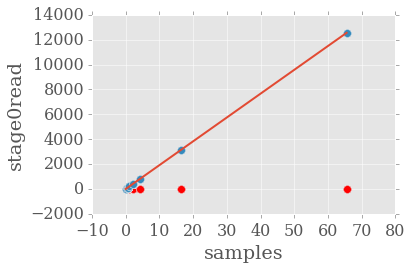

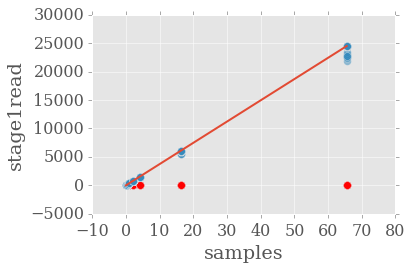

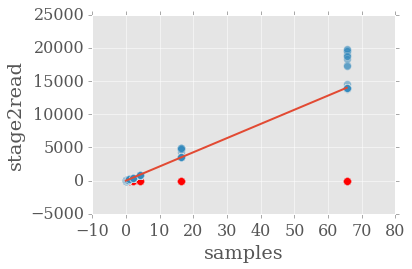

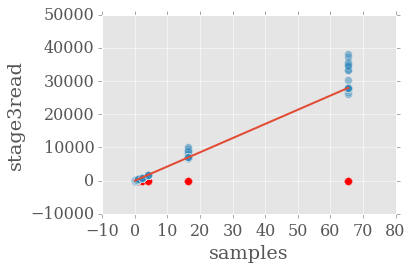

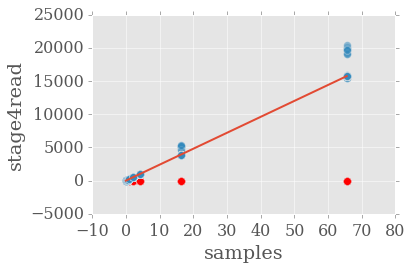

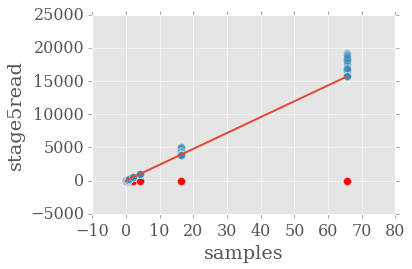

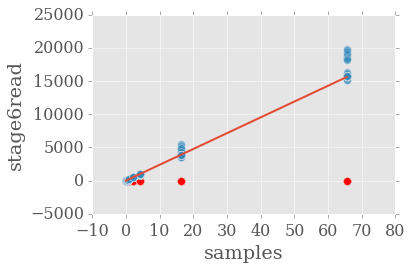

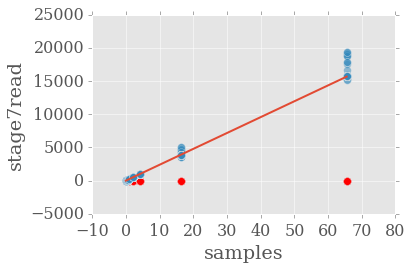

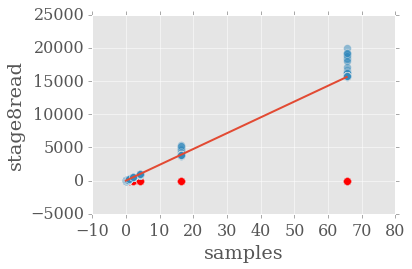

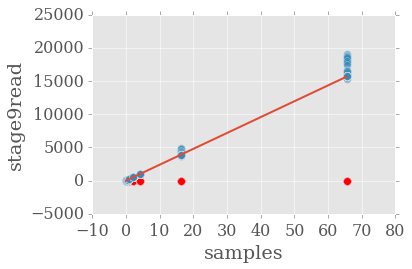

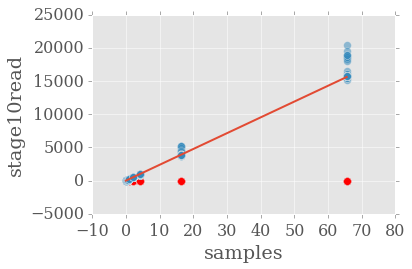

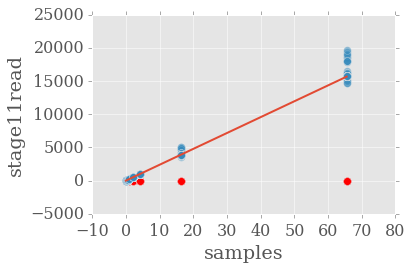

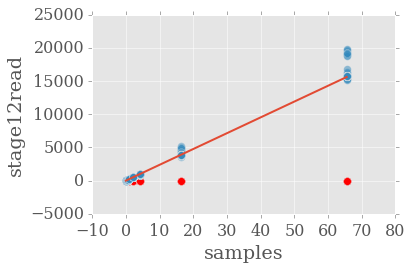

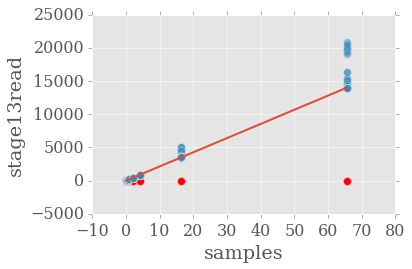

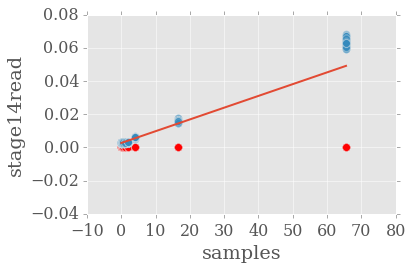

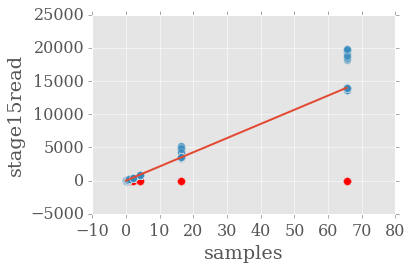

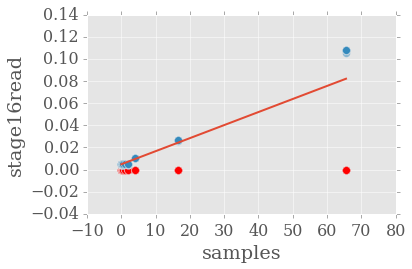

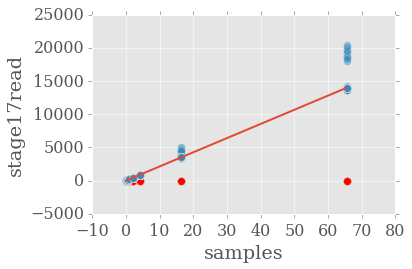

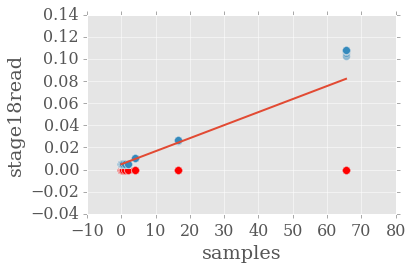

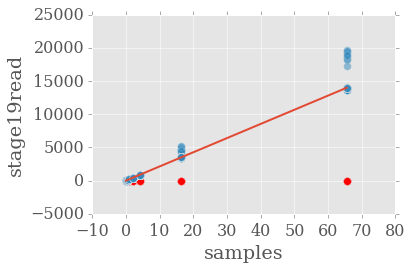

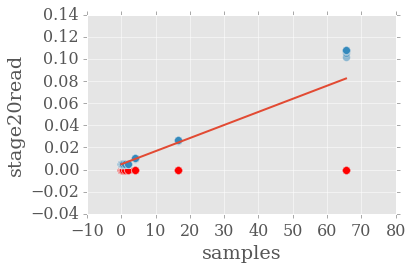

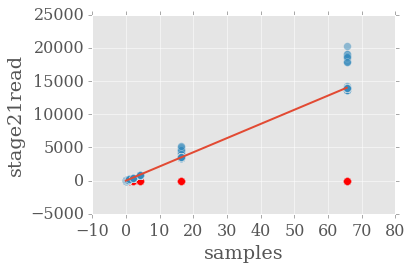

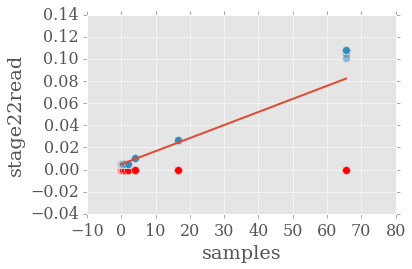

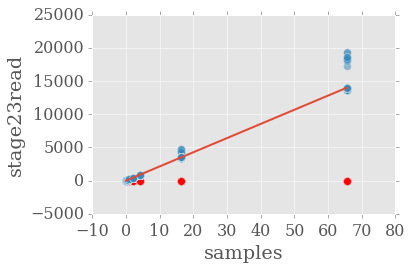

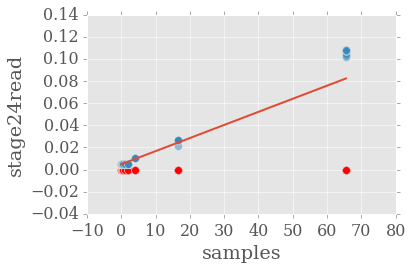

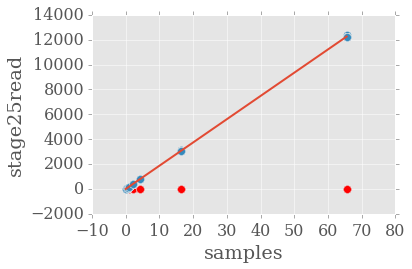

In [11]:
# Build graphs to understand how data grows as we increase the number of samples
# - Select a stage
# - Consider all number of workers
# - x: number of samples
# - y1: data read (scatterplot)
# - y2: data written (scatterplot)
def plot_stage(stage_id):
    x = 'samples'
    y1 = 'stage{:d}read'.format(stage_id)
    y2 = 'stage{:d}written'.format(stage_id)
    graph_df = pd.DataFrame()
    _df = df#[df[x] < 16]
    graph_df[x] = _df[x]
    graph_df[y1] = _df[y1] / 1024  # to MB
    graph_df[y2] = _df[y2] / 1024  # to MB
    alpha=0.5
    
    ax = graph_df.plot.scatter(x, y2, s=60, c='r', alpha=alpha)
    graph_df.plot.scatter(x, y1, s=60, alpha=alpha, ax=ax)
    
    prof_df = graph_df[[x, y1]][graph_df.samples < 16]
    x_max = graph_df[x].max()
    plot_data_size_prediction(ax, prof_df, x_max)
    
    plt.tight_layout()
    plt.show()
    
    #list_points(graph_df[[x, y1]])
    #list_points(graph_df[[x, y2]])
    
import numpy as np

def plot_data_size_prediction(ax, df, x_max):
    x, y = df.columns
    z = np.polyfit(df[x], df[y], 1)
    p = np.poly1d(z)
    xs = np.linspace(0, x_max, x_max)
    ax.plot(xs, p(xs))
    
from IPython.display import display
    
def list_points(df):
    col1, col2 = df.columns
    counts = df.groupby(col1).apply(lambda x: x[col2].value_counts())
    display(counts)

import matplotlib.pyplot as plt
    
for stage in range(len(apps[0].stages)):
    plot_stage(stage)
    